# **Capstone project: Providing data-driven suggestions for HR**

🗒
### Understand the business scenario and problem

The HR department at Salifort Motors wants to take some initiatives to improve employee satisfaction levels at the company. They collected data from employees, but now they don’t know what to do with it. They refer to you as a data analytics professional and ask you to provide data-driven suggestions based on your understanding of the data. They have the following question: what’s likely to make the employee leave the company?

Your goals in this project are to analyze the data collected by the HR department and to build a model that predicts whether or not an employee will leave the company.

If you can predict employees likely to quit, it might be possible to identify factors that contribute to their leaving. Because it is time-consuming and expensive to find, interview, and hire new employees, increasing employee retention will be beneficial to the company.

### Familiarize yourself with the HR dataset

The dataset that you'll be using in this lab contains 15,000 rows and 10 columns for the variables listed below. 

**Note:** you don't need to download any data to complete this lab. For more information about the data, refer to its source on [Kaggle](https://www.kaggle.com/datasets/mfaisalqureshi/hr-analytics-and-job-prediction?select=HR_comma_sep.csv).

Variable  |Description |
-----|-----|
satisfaction_level|Employee-reported job satisfaction level [0&ndash;1]|
last_evaluation|Score of employee's last performance review [0&ndash;1]|
number_project|Number of projects employee contributes to|
average_monthly_hours|Average number of hours employee worked per month|
time_spend_company|How long the employee has been with the company (years)
Work_accident|Whether or not the employee experienced an accident while at work
left|Whether or not the employee left the company
promotion_last_5years|Whether or not the employee was promoted in the last 5 years
Department|The employee's department
salary|The employee's salary (U.S. dollars)

### Import packages

In [53]:
import numpy as np
import pandas as pd 
import datetime

import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import recall_score, precision_score, f1_score,accuracy_score, roc_auc_score,\
confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay

from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier, plot_importance

import pickle

pd.options.display.max_columns = None 

In [2]:
df = pd.read_csv("HR_capstone_dataset.csv")
df.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,Department,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low


### Gather basic information about the data

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   satisfaction_level     14999 non-null  float64
 1   last_evaluation        14999 non-null  float64
 2   number_project         14999 non-null  int64  
 3   average_montly_hours   14999 non-null  int64  
 4   time_spend_company     14999 non-null  int64  
 5   Work_accident          14999 non-null  int64  
 6   left                   14999 non-null  int64  
 7   promotion_last_5years  14999 non-null  int64  
 8   Department             14999 non-null  object 
 9   salary                 14999 non-null  object 
dtypes: float64(2), int64(6), object(2)
memory usage: 1.1+ MB


### Gather descriptive statistics about the data

In [4]:
df.describe(include='all')

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,Department,salary
count,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999,14999
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10,3
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,sales,low
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4140,7316
mean,0.612834,0.716102,3.803054,201.050337,3.498233,0.144610,0.238083,0.021268,NaN,NaN
std,0.248631,0.171169,1.232592,49.943099,1.460136,0.351719,0.425924,0.144281,NaN,NaN
min,0.090000,0.360000,2.000000,96.000000,2.000000,0.000000,0.000000,0.000000,NaN,NaN
25%,0.440000,0.560000,3.000000,156.000000,3.000000,0.000000,0.000000,0.000000,NaN,NaN
50%,0.640000,0.720000,4.000000,200.000000,3.000000,0.000000,0.000000,0.000000,NaN,NaN
75%,0.820000,0.870000,5.000000,245.000000,4.000000,0.000000,0.000000,0.000000,NaN,NaN


### Rename columns

As a data cleaning step, rename the columns as needed. Standardize the column names so that they are all in `snake_case`, correct any column names that are misspelled, and make column names more concise as needed.

In [5]:
df.rename(columns={'number_project':'number_projects','average_montly_hours':'average_monthly_hours','Work_accident':'work_accident','Department':'department'}, inplace=True)
df.head()

,satisfaction_level,last_evaluation,number_projects,average_monthly_hours,time_spend_company,work_accident,left,promotion_last_5years,department,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low


### Check duplicates

Check for any duplicate entries in the data.

In [6]:
df.duplicated().sum()

3008

In [7]:
df.drop(df[df.duplicated()].index, inplace=True)

In [8]:
df.shape

(11991, 10)

### Data visualizations

Now, start examining the variables that you're interested in, and create plots to visualize relationships between variables in the data.

In [9]:
df.columns

Index(['satisfaction_level', 'last_evaluation', 'number_projects',
       'average_monthly_hours', 'time_spend_company', 'work_accident', 'left',
       'promotion_last_5years', 'department', 'salary'],
      dtype='object')

satisfaction_level & left

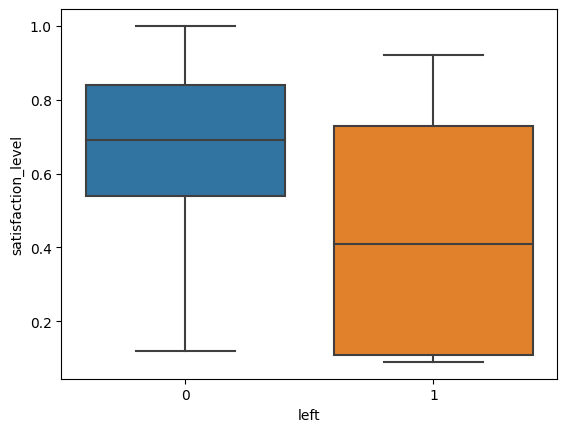

In [10]:
sns.boxplot(y=df['satisfaction_level'], x=df['left']);

Good indicator

* last_evaluation & left

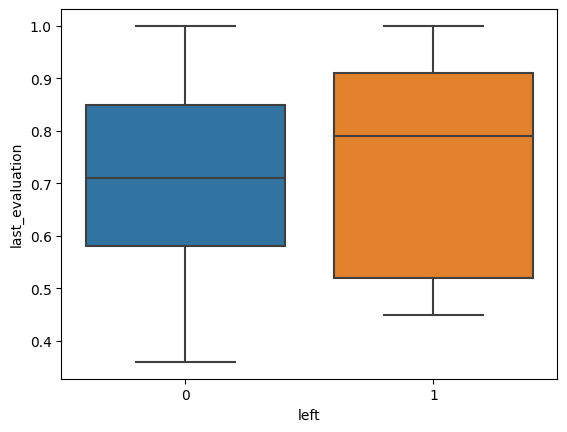

In [11]:
sns.boxplot(y=df['last_evaluation'], x=df['left']);

(last_evaluation + salary) & left

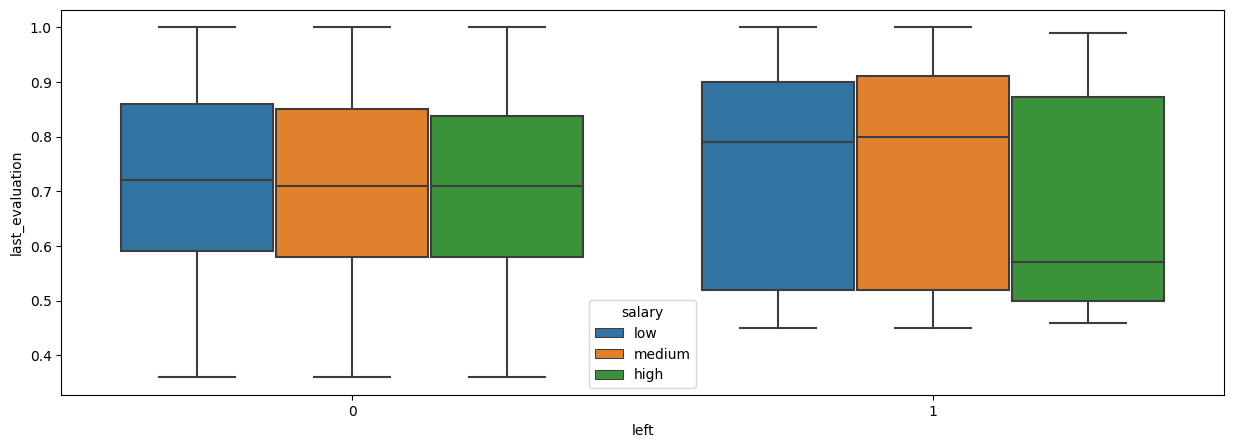

In [12]:
plt.figure(figsize=(15,5))
sns.boxplot(y=df['last_evaluation'], x=df['left'], hue=df['salary']);

Employees with low salary tend to leave if evalueted high.\
Employees with low salary tend to leave if evalueted low.

* number_projects

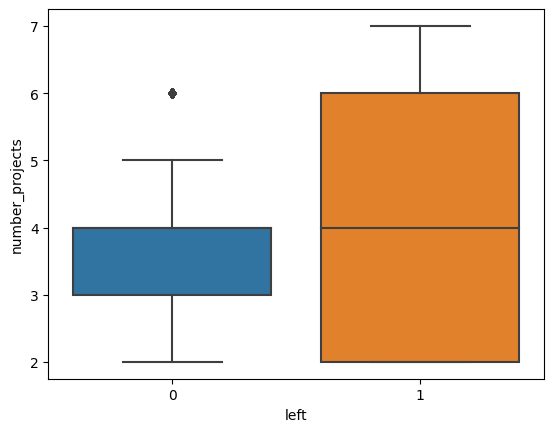

In [13]:
sns.boxplot(y=df['number_projects'], x=df['left']);

Hard to make inferrence

* average_monthly_hours

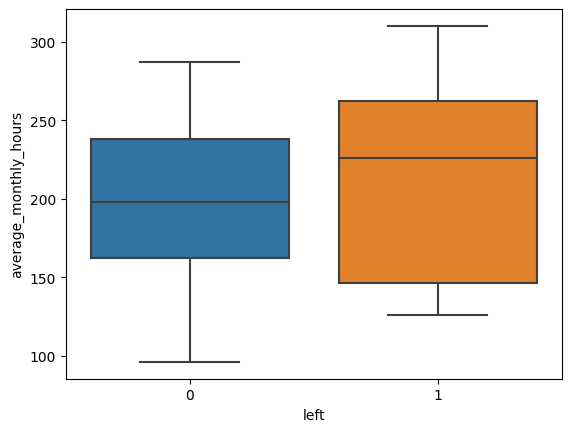

In [14]:
sns.boxplot(y=df['average_monthly_hours'], x=df['left']);

Employees with higher load tend to leave more often.

* time_spend_company

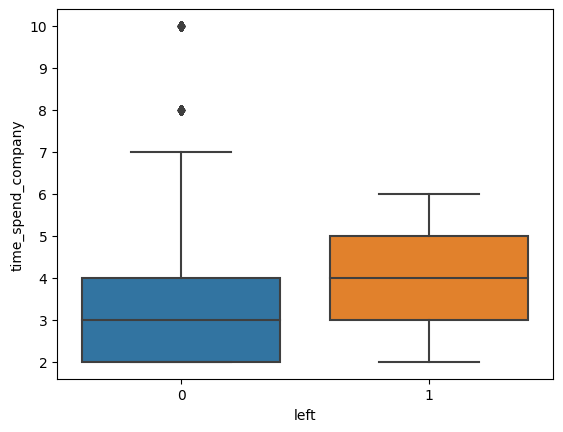

In [15]:
sns.boxplot(y=df['time_spend_company'], x=df['left']);

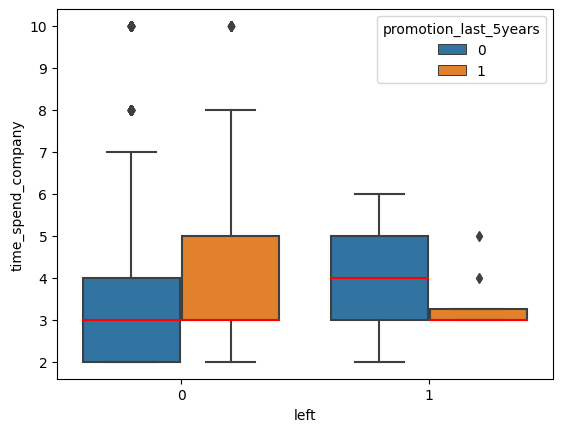

In [16]:
sns.boxplot(y=df['time_spend_company'], x=df['left'], hue=df['promotion_last_5years'], medianprops={'color': 'red'});

In [17]:
df.loc[df['promotion_last_5years']==0]['left'].value_counts()

0    9805
1    1983
Name: left, dtype: int64

In [18]:
df.loc[df['promotion_last_5years']==1]['left'].value_counts()

0    195
1      8
Name: left, dtype: int64

Between employees who was not promoted last 5 years, employees with higher tenure tend to leave more often.

* department

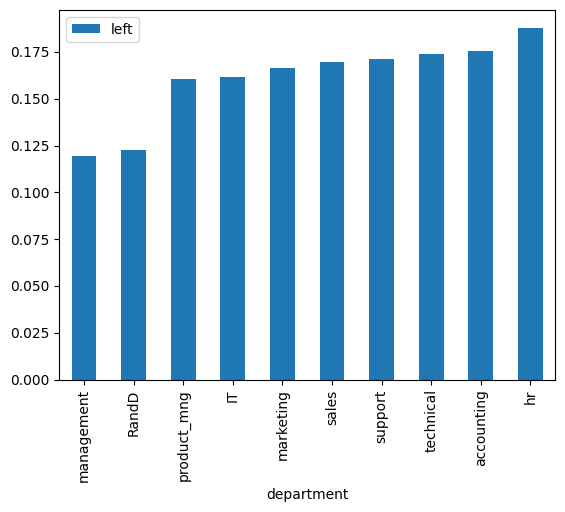

In [32]:
# left %
df[['department', 'left']].groupby(by='department').mean().sort_values('left').plot.bar();

* salary

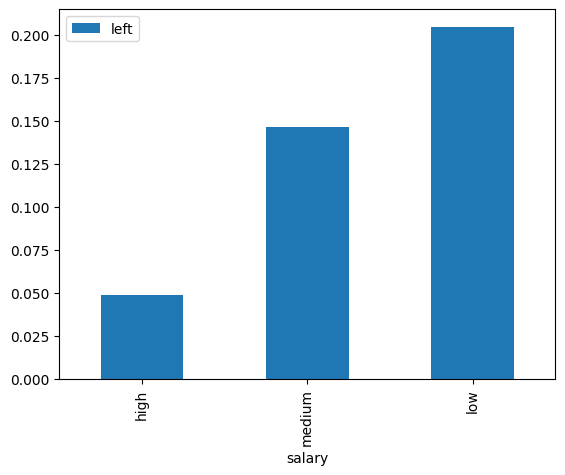

In [35]:
# left %
df[['salary', 'left']].groupby(by='salary').mean().sort_values('left').plot.bar();

In [44]:
df['salary'].replace({'low':1, 'medium':2, 'high':3}, inplace=True)

### Modeling

Add as many cells as you need to conduct the modeling process.

In [45]:
y = df['left']
X = df.drop(['left', 'department'], axis=1)

In [46]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, stratify=y, random_state=42)

In [47]:
xgb = XGBClassifier(objective='binary:logistic', random_state=0) 

cv_params = {'max_depth': [8, 10,15], 
             'min_child_weight': [4, 6, 8],
             'learning_rate': [0.05, 0.1, 0.3],
             'n_estimators': [80, 150, 250]
             }    

scoring = {'accuracy', 'precision', 'recall', 'roc_auc'}

xgb_cv1 = GridSearchCV(xgb, cv_params, scoring=scoring, cv=5, refit='recall')

In [48]:
%%time
xgb_cv1.fit(X_train, y_train)

CPU times: total: 26min 29s
Wall time: 3min 41s


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=0, ...),
             param_grid={'learning_rate': [0.05, 0.1, 0.3],
                         'max_depth': [8, 10, 15],
                         'min_child_weight': [4, 6, 8],
                         'n_estimators': [80, 150, 250]},
             refit='recall',
             scoring={'accuracy', 'precision', 'recall', 'roc_auc'})

In [55]:
# with open('project7_xgb.pickle', 'wb') as to_write:
#     pickle.dump(xgb_cv1, to_write) 

In [49]:
xgb_cv1.best_score_

0.9112970711297071

In [50]:
xgb_cv1.best_params_

{'learning_rate': 0.3,
 'max_depth': 8,
 'min_child_weight': 4,
 'n_estimators': 150}

In [51]:
y_pred = xgb_cv1.best_estimator_.predict(X_test)

In [63]:
print('F1 test score {:.3f}'.format(f1_score(y_test, y_pred)))
print('Recall test score {:.3f}'.format(recall_score(y_test, y_pred)))
print('Precision test score {:.3f}'.format(precision_score(y_test, y_pred)))
print('Accuracy test score {:.3f}'.format(accuracy_score(y_test, y_pred)))
print('ROC AUC test score {:.3f}'.format(roc_auc_score(y_test, y_pred)))

F1 test score 0.943
Recall test score 0.926
Precision test score 0.961
Accuracy test score 0.981
ROC AUC test score 0.959


# The second model

In [56]:
cv_params2 = {'max_depth': [6, 7, 8], 
             'min_child_weight': [2, 3, 4],
             'learning_rate': [0.3, 0.5],
             'n_estimators': [125, 150, 175]
             }    

xgb_cv2 = GridSearchCV(xgb, cv_params2, scoring=scoring, cv=5, refit='recall')

In [57]:
%%time
xgb_cv2.fit(X_train, y_train)

CPU times: total: 14min 34s
Wall time: 2min 3s


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=0, ...),
             param_grid={'learning_rate': [0.3, 0.5], 'max_depth': [6, 7, 8],
                         'min_child_weight': [2, 3, 4],
                         'n_estimators': [125, 150, 175]},
             refit='recall',
             scoring={'accuracy', 'precision', 'recall', 'roc_auc'})

In [64]:
# with open('project7_xgb2.pickle', 'wb') as to_write:
#     pickle.dump(xgb_cv2, to_write) 

In [58]:
xgb_cv2.best_score_

0.9121338912133892

In [59]:
xgb_cv2.best_params_

{'learning_rate': 0.3,
 'max_depth': 7,
 'min_child_weight': 2,
 'n_estimators': 125}

In [60]:
y_pred2 = xgb_cv2.best_estimator_.predict(X_test)

In [62]:
print('F1 test score {:.3f}'.format(f1_score(y_test, y_pred2)))
print('Recall test score {:.3f}'.format(recall_score(y_test, y_pred2)))
print('Precision test score {:.3f}'.format(precision_score(y_test, y_pred2)))
print('Accuracy test score {:.3f}'.format(accuracy_score(y_test, y_pred2)))
print('ROC AUC test score {:.3f}'.format(roc_auc_score(y_test, y_pred2)))

F1 test score 0.946
Recall test score 0.926
Precision test score 0.967
Accuracy test score 0.982
ROC AUC test score 0.960


the second model is better

# The third model

In [67]:
cv_params3 = {'max_depth': [7], 
             'min_child_weight': [0, 1, 2],
             'learning_rate': [0.3],
             'n_estimators': [100, 125, 150]
             }    

xgb_cv3 = GridSearchCV(xgb, cv_params3, scoring=scoring, cv=5, refit='recall')

In [68]:
%%time
xgb_cv3.fit(X_train, y_train)

CPU times: total: 2min 7s
Wall time: 19.5 s


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=0, ...),
             param_grid={'learning_rate': [0.3], 'max_depth': [7],
                         'min_child_weight': [0, 1, 2],
                         'n_estimators': [100, 125, 150]},
             refit='recall',
             scoring={'accuracy', 'precision', 'recall', 'roc_auc'})

In [73]:
# with open('project7_xgb3.pickle', 'wb') as to_write:
#     pickle.dump(xgb_cv3, to_write) 

In [69]:
xgb_cv3.best_score_

0.9154811715481171

In [70]:
xgb_cv3.best_params_

{'learning_rate': 0.3,
 'max_depth': 7,
 'min_child_weight': 0,
 'n_estimators': 100}

In [71]:
y_pred3 = xgb_cv3.best_estimator_.predict(X_test)

In [72]:
print('F1 test score {:.3f}'.format(f1_score(y_test, y_pred3)))
print('Recall test score {:.3f}'.format(recall_score(y_test, y_pred3)))
print('Precision test score {:.3f}'.format(precision_score(y_test, y_pred3)))
print('Accuracy test score {:.3f}'.format(accuracy_score(y_test, y_pred3)))
print('ROC AUC test score {:.3f}'.format(roc_auc_score(y_test, y_pred3)))

F1 test score 0.950
Recall test score 0.928
Precision test score 0.972
Accuracy test score 0.984
ROC AUC test score 0.962


The third is better 

In [74]:
cv_params4 = {'max_depth': [7], 
             'min_child_weight': [0],
             'learning_rate': [0.3],
             'n_estimators': [100],
              'alpha': [0.00001, 0.0001, 0.001, 0.01, 0.1]
             }    

xgb_cv4 = GridSearchCV(xgb, cv_params4, scoring=scoring, cv=5, refit='recall')

In [75]:
%%time
xgb_cv4.fit(X_train, y_train)

CPU times: total: 1min 7s
Wall time: 9.84 s


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=0, ...),
             param_grid={'alpha': [1e-05, 0.0001, 0.001, 0.01, 0.1],
                         'learning_rate': [0.3], 'max_depth': [7],
                         'min_child_weight': [0], 'n_estimators': [100]},
             refit='recall',
             scoring={'accuracy', 'precision', 'recall', 'roc_auc'})

In [76]:
xgb_cv4.best_score_

0.9171548117154812

In [78]:
xgb_cv4.best_params_

{'alpha': 0.01,
 'learning_rate': 0.3,
 'max_depth': 7,
 'min_child_weight': 0,
 'n_estimators': 100}

In [79]:
y_pred4 = xgb_cv4.best_estimator_.predict(X_test)

In [80]:
print('F1 test score {:.3f}'.format(f1_score(y_test, y_pred4)))
print('Recall test score {:.3f}'.format(recall_score(y_test, y_pred4)))
print('Precision test score {:.3f}'.format(precision_score(y_test, y_pred4)))
print('Accuracy test score {:.3f}'.format(accuracy_score(y_test, y_pred4)))
print('ROC AUC test score {:.3f}'.format(roc_auc_score(y_test, y_pred4)))

F1 test score 0.950
Recall test score 0.927
Precision test score 0.974
Accuracy test score 0.984
ROC AUC test score 0.961


Almost as the third model

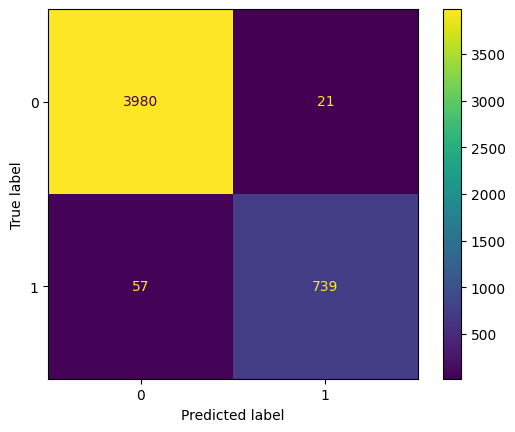

In [81]:
cm = confusion_matrix(y_test, y_pred3, labels=xgb_cv3.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=xgb_cv3.classes_)
disp.plot();

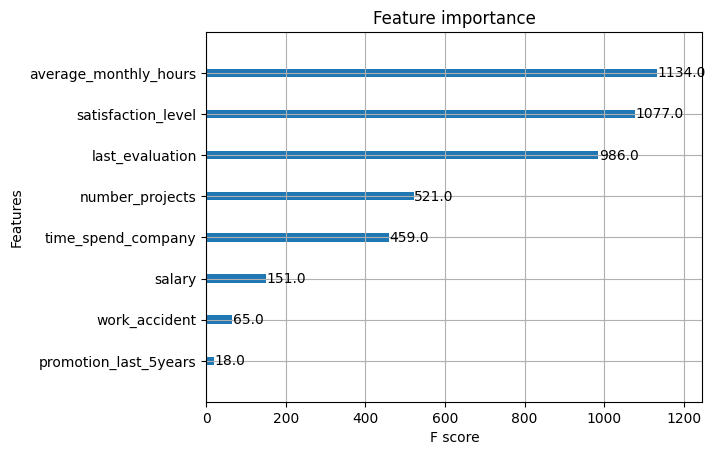

In [84]:
plot_importance(xgb_cv3.best_estimator_);